In [9]:
import pandas as pd
import numpy as np
from helpers import *
import ast
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

In [10]:
years = ['twenty2','twenty3','twenty4']
strategies = [
            'CDLOSEC_2H',
            'CDLOSEP_2H'
              ]
week_dfs = []

for year in years:
    year_data = YEAR_CONFIG[year]
    for file_name in year_data['all_files']:
        for strategy in strategies:
            try:
                week_df = pd.read_csv(f"/Users/charlesmiller/Documents/backtesting_data/TREND55-ALLSEV/{strategy}/{file_name}.csv")
                if strategy == 'CDLOSEP_2H':
                    week_df['side'] = 'P'
                week_dfs.append(week_df)
            except FileNotFoundError:
                print(f"File {file_name} not found")
                continue

all_data = pd.concat(week_dfs)


File 2024-07-01 not found
File 2024-07-01 not found
File 2024-07-08 not found
File 2024-07-08 not found
File 2024-07-15 not found
File 2024-07-15 not found
File 2024-07-22 not found
File 2024-07-22 not found
File 2024-07-29 not found
File 2024-07-29 not found
File 2024-08-05 not found
File 2024-08-05 not found
File 2024-08-12 not found
File 2024-08-12 not found
File 2024-08-19 not found
File 2024-08-19 not found
File 2024-08-26 not found
File 2024-08-26 not found
File 2024-09-02 not found
File 2024-09-02 not found
File 2024-09-09 not found
File 2024-09-09 not found
File 2024-09-16 not found
File 2024-09-16 not found
File 2024-09-23 not found
File 2024-09-23 not found
File 2024-09-30 not found
File 2024-09-30 not found
File 2024-10-07 not found
File 2024-10-07 not found
File 2024-10-14 not found
File 2024-10-14 not found
File 2024-10-21 not found
File 2024-10-21 not found
File 2024-10-28 not found
File 2024-10-28 not found
File 2024-11-04 not found
File 2024-11-04 not found
File 2024-11

In [11]:
def build_contract_df(row):
    contract = ast.literal_eval(row['contracts'])
    last_price = get_last_price(row)
    row['alert_price'] = last_price
    if len(contract) == 0:
        return pd.DataFrame()
    ## turn a list into a df
    contract_df = pd.DataFrame(contract)
    contract_df.rename(columns={0:'contract_name'}, inplace=True)
    contract_df[['strike','expiry']] = contract_df['contract_name'].apply(lambda x: extract_strike_price(x,row['side']))
    ## find index of the contract with the strike price greater than row['alert_price']
    expiries = ast.literal_eval(row['expiries'])
    contract_dfs = []
    for expiry in expiries:
        expiry_df = contract_df[contract_df['expiry'] == expiry].reset_index(drop=True)
        if row['side'] == 'C':
            select_contracts = expiry_df[expiry_df['strike'] > row['alert_price']]
            select_contracts.sort_values(by='strike', ascending=True, inplace=True)
        elif row['side'] == 'P':
            select_contracts = expiry_df[expiry_df['strike'] < row['alert_price']]
            select_contracts.sort_values(by='strike', ascending=False, inplace=True)
        idx_break = select_contracts.index[0]
        select_contracts = expiry_df.iloc[(idx_break-1):(idx_break+4)]
        # if len(select_contracts) < 5:
        #     print(contract_df)
        #     print(expiry_df)
        #     print(expiry)
        #     print(row['alert_price'])   
        contract_dfs.append(select_contracts)
    for contract_df in contract_dfs:
        # print("LEN CONTRACT DF 3", len(contract_df))
        try:
            contract_df[["max_price","min_price","max_time_diff","min_time_diff","open_price","median_price_appreication"]] = contract_df.apply(lambda x: calculate_contract_price_statistics(x,row), axis=1, result_type='expand')
            contract_df['max_appreciation'] = (contract_df['max_price'] - contract_df['open_price'])/contract_df['open_price']
            contract_df['max_depreciation'] = (contract_df['min_price'] - contract_df['open_price'])/contract_df['open_price']
            contract_df['strategy'] = row['strategy']
            contract_df['side'] = row['side']
            contract_df['probability'] = row['probabilities']
            contract_df['label'] = row['label']
            contract_df['date'] = row['dt']
            contract_df['hour'] = row['hour']
            contract_df['minute'] = row['minute']
            contract_df.reset_index(drop=True, inplace=True)
            contract_df['spread_position'] = contract_df.index
        except Exception as e:
            # print(e)
            # print(contract_df)
            # print(row)
            # print()
            continue
    full_contract_df = pd.concat(contract_dfs)
    return full_contract_df

def categorize_week(row):
    if row['symbol'] in ['SPY','QQQ','IWM']:
        if row['day_of_week'] == 1:
            return 'wk0'
        else:
            return 'wk1'
    if row['day_of_week'] == 'Monday':
        if row['days_to_expiry'] == 4:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Tuesday':
        if row['days_to_expiry'] == 3:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Wednesday':
        if row['days_to_expiry'] == 2:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Thursday':
        if row['days_to_expiry'] == 1:
            return 'wk0'
        else:
            return 'wk1'
    elif row['day_of_week'] == 'Friday':
        if row['days_to_expiry'] == 0:
            return 'wk0'
        elif row['days_to_expiry'] == 7:
            return 'wk1'
        else:
            return 'wk2'
    
    

In [12]:
option_price_analytics_dfs =[]
all_data.reset_index(drop=True, inplace=True)
for idx, row in all_data.iterrows():
    try:
        contract_df = build_contract_df(row)
        option_price_analytics_dfs.append(contract_df)
    except Exception as e:
        print(e)
        print(row['symbol'])
        print(idx)
        print()
        continue

index 0 is out of bounds for axis 0 with size 0
META
142

index 0 is out of bounds for axis 0 with size 0
META
153

index 0 is out of bounds for axis 0 with size 0
META
295

index 0 is out of bounds for axis 0 with size 0
META
307

index 0 is out of bounds for axis 0 with size 0
META
312

index 0 is out of bounds for axis 0 with size 0
META
323

index 0 is out of bounds for axis 0 with size 0
META
345

index 0 is out of bounds for axis 0 with size 0
META
369

index 0 is out of bounds for axis 0 with size 0
META
411

index 0 is out of bounds for axis 0 with size 0
META
417

index 0 is out of bounds for axis 0 with size 0
QQQ
423

index 0 is out of bounds for axis 0 with size 0
SPY
424

index 0 is out of bounds for axis 0 with size 0
META
427

index 0 is out of bounds for axis 0 with size 0
QQQ
433

index 0 is out of bounds for axis 0 with size 0
QQQ
438

index 0 is out of bounds for axis 0 with size 0
SPY
446

index 0 is out of bounds for axis 0 with size 0
META
450

index 0 is out of b

KeyboardInterrupt: 

In [ ]:
fopa = pd.concat(option_price_analytics_dfs)
fopa.to_csv("option_price_analytics_LOSE.csv", index=False)

In [ ]:
df_null = fopa[fopa['date'].isna()]
df_null

,contract_name,strike,expiry,max_price,min_price,max_time_diff,min_time_diff,open_price,median_price_appreication,max_appreciation,max_depreciation,strategy,side,probability,label,date,hour,minute,spread_position
41,O:GOOG220408P02740000,2740.0,220408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,O:GOOG220408P02750000,2750.0,220408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,O:AMZN221202P00092000,92.0,221202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,O:AMZN221202P00093000,93.0,221202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,O:AMZN221202P00094000,94.0,221202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,O:AMZN221202P00095000,95.0,221202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18,O:AMZN221202P00096000,96.0,221202,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,O:AMZN221209P00092000,92.0,221209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,O:AMZN221209P00093000,93.0,221209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,O:AMZN221209P00094000,94.0,221209,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
fopa["contract_time"] = fopa["date"].apply(lambda x: pd.to_datetime(x).strftime('%y%m%d'))
fopa['days_to_expiry'] = (pd.to_datetime(fopa["expiry"], format='%y%m%d') - (pd.to_datetime(fopa["contract_time"], format='%y%m%d')))
fopa['days_to_expiry'] = fopa['days_to_expiry'].dt.days
fopa['day_of_week'] = pd.to_datetime(fopa['date']).dt.day_name()
fopa['symbol'] = fopa['contract_name'].apply(lambda x: x[2:-15])
fopa['exp_week'] = fopa.apply(lambda x: categorize_week(x), axis=1)


ValueError: NaTType does not support strftime

In [ ]:
fopa['max_appreciation'].describe()

count    115642.000000
mean          1.818903
std           2.958765
min          -0.990000
25%          -0.040000
50%           0.970000
75%           2.580000
max          34.800000
Name: max_appreciation, dtype: float64

In [ ]:
fopa.loc[fopa['label']== 1]['max_appreciation'].describe()

count    78542.000000
mean         1.979810
std          3.058806
min         -0.990000
25%          0.050000
50%          1.100000
75%          2.790000
max         34.800000
Name: max_appreciation, dtype: float64

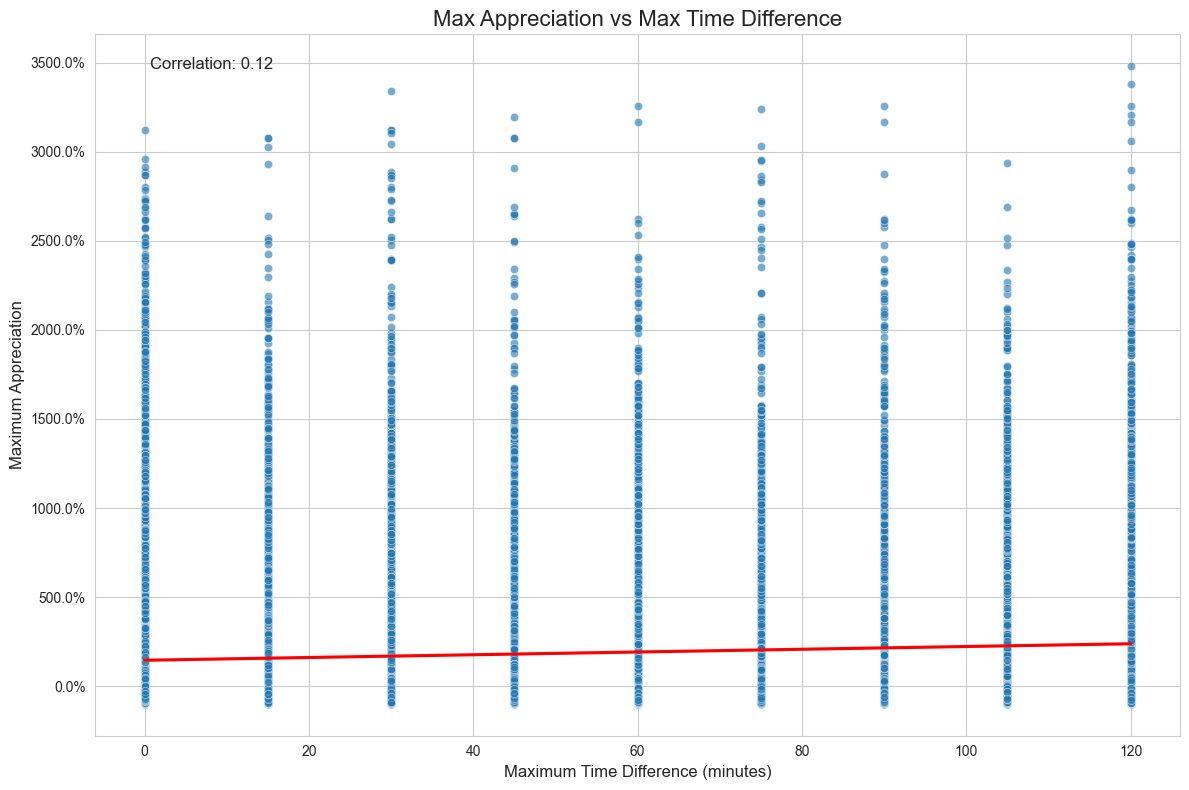

In [ ]:
fopa.reset_index(drop=True, inplace=True)
# Set the style for the plot
sns.set_style("whitegrid")

# Create the scatter plot
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    data=fopa,
    x='max_time_diff',
    y='max_appreciation',
    alpha=0.6
)

# Add a trend line
sns.regplot(
    data=fopa,
    x='max_time_diff',
    y='max_appreciation',
    scatter=False,
    color='red'
)

# Customize the plot
plt.title('Max Appreciation vs Max Time Difference', fontsize=16)
plt.xlabel('Maximum Time Difference (minutes)', fontsize=12)
plt.ylabel('Maximum Appreciation', fontsize=12)

# Format y-axis as percentage
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.1%}'.format(y)))

# Add text for correlation
correlation = fopa['max_time_diff'].corr(fopa['max_appreciation'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.2f}', 
         transform=plt.gca().transAxes, fontsize=12)

# Improve the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
result = fopa[(fopa['label'] == 1) & (fopa['max_time_diff'] > 0)].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,11708.0,2.546833,3.339998,-0.99,0.45,1.57,3.50,34.80
Monday,11032.0,2.458364,3.242318,-0.99,0.31,1.45,3.45,31.06
Thursday,14496.0,1.655615,2.819198,-0.99,-0.15,0.88,2.45,33.40
Tuesday,13897.0,2.079120,2.880943,-0.99,0.20,1.22,2.90,26.71
Wednesday,13778.0,1.931804,3.147743,-0.99,0.08,1.05,2.60,32.43


In [ ]:
result = fopa[(fopa['label'] == 1) & (fopa['max_time_diff'] > 0) & (fopa['exp_week'] == 'wk0')].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Monday,4591.0,1.933594,2.851282,-0.99,0.02,1.05,2.90,24.80
Thursday,5711.0,0.798112,2.386580,-0.99,-0.63,0.08,1.21,30.43
Tuesday,5562.0,1.455645,2.407217,-0.99,-0.20,0.71,2.30,23.50
Wednesday,5581.0,1.206635,2.679143,-0.99,-0.40,0.40,1.74,28.85


In [ ]:
result = fopa[(fopa['label'] == 1) & (fopa['max_time_diff'] > 0) & (fopa['exp_week'] == 'wk1')].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,6517.0,1.976228,2.861431,-0.99,0.21,1.20,2.80,34.80
Monday,6441.0,2.832408,3.446203,-0.96,0.56,1.75,3.90,31.06
Thursday,8785.0,2.213064,2.936649,-0.98,0.37,1.42,3.00,33.40
Tuesday,8335.0,2.495169,3.088669,-0.99,0.52,1.55,3.35,26.71
Wednesday,8197.0,2.425542,3.341642,-0.97,0.50,1.47,3.01,32.43


In [ ]:
result = fopa[(fopa['label'] == 1) & (fopa['max_time_diff'] > 0) & (fopa['exp_week'] == 'wk2')].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,5191.0,3.263194,3.736533,-0.99,0.85,2.1,4.41,33.83


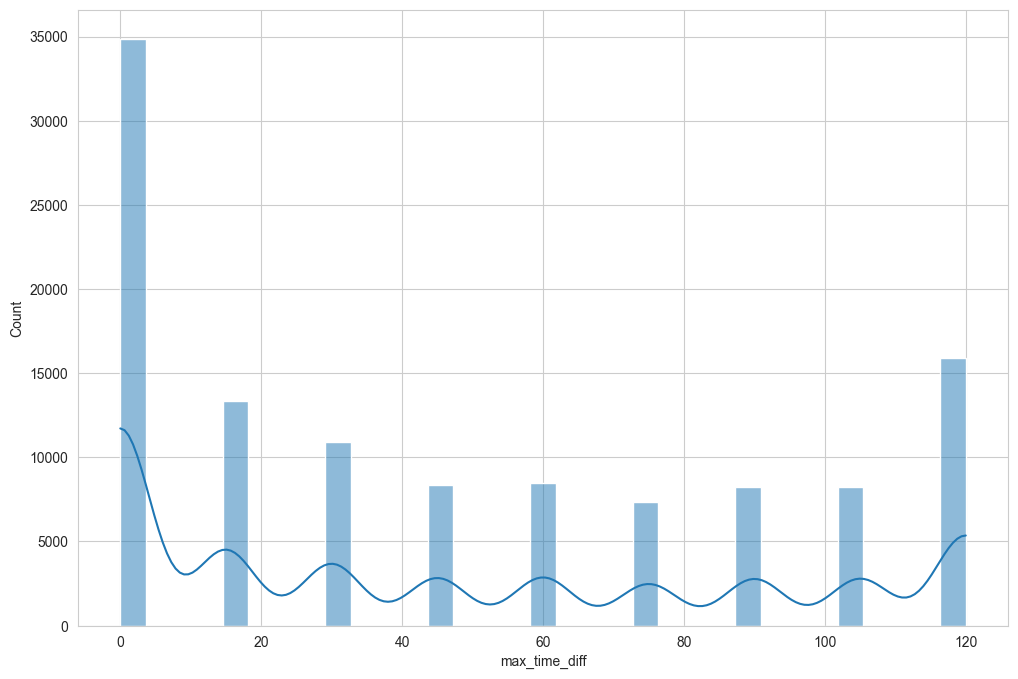

In [ ]:
## create a histogram of the max_time_diff
plt.figure(figsize=(12, 8))
hist = sns.histplot(
    data=fopa,
    x='max_time_diff',
    kde=True
)
# result = fopa[fopa['label'] == 1].groupby('day_of_week')['max_time_diff'].describe()


In [ ]:
result = fopa[fopa['label'] == 1].groupby('day_of_week')['max_depreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,14690.0,1.589607,2.606128,-0.99,-0.03,0.83,2.25,23.00
Monday,12993.0,1.478142,2.549395,-0.99,-0.19,0.70,2.20,31.06
Thursday,17385.0,0.590551,2.053389,-0.99,-0.64,0.00,1.02,29.30
Tuesday,16893.0,1.157180,2.275148,-0.99,-0.31,0.47,1.72,19.30
Wednesday,16581.0,0.975429,2.542196,-0.99,-0.44,0.26,1.39,29.70


In [ ]:
result = fopa[fopa['label'] == 0].groupby('day_of_week')['max_appreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,7008.0,2.223824,3.264601,-0.98,0.2275,1.25,2.9725,30.25
Monday,5810.0,1.946692,3.019538,-0.99,0.0600,1.10,2.7500,31.20
Thursday,8184.0,0.851204,1.992545,-0.99,-0.5100,0.28,1.5000,21.60
Tuesday,8041.0,1.373431,2.390176,-0.99,-0.1800,0.68,2.0500,20.44
Wednesday,8057.0,1.233522,2.639880,-0.99,-0.2700,0.53,1.7300,29.35


In [ ]:
result = fopa[fopa['label'] == 0].groupby('day_of_week')['max_depreciation'].describe()
result

,count,mean,std,min,25%,50%,75%,max
day_of_week,,,,,,,,
Friday,7008.0,1.507951,2.773190,-0.99,-0.15,0.66,2.10,27.62
Monday,5810.0,1.206174,2.488348,-0.99,-0.32,0.50,1.82,28.89
Thursday,8184.0,0.215795,1.517538,-0.99,-0.77,-0.28,0.63,17.25
Tuesday,8041.0,0.756632,1.984250,-0.99,-0.50,0.14,1.24,18.75
Wednesday,8057.0,0.587349,2.197956,-0.99,-0.59,-0.02,0.91,27.20
